# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import imblearn
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import Image
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Your code here
fraud = pd.read_csv('Lab_fraud.csv').sample(100000)
fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2482627,204,PAYMENT,9475.44,C103356144,113739.42,104263.97,M313911819,0.00,0.00,0,0
4216035,305,CASH_IN,197518.98,C1699217828,3940239.58,4137758.56,C1866147580,214459.05,16940.06,0,0
3859197,283,CASH_IN,141342.25,C1111650642,9689512.16,9830854.41,C1860406549,2230725.42,2089383.17,0,0
2350094,189,PAYMENT,4560.30,C1164392049,0.00,0.00,M331330769,0.00,0.00,0,0
4365650,310,CASH_OUT,26442.51,C1612544930,0.00,0.00,C2077847626,1268327.91,1294770.43,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3593148,262,CASH_OUT,270906.33,C1539709347,0.00,0.00,C1455974254,5373757.16,5644663.48,0,0
668899,36,CASH_IN,176750.79,C1518184008,99576.00,276326.79,C1490504925,0.00,0.00,0,0
627034,34,CASH_OUT,104628.58,C538250270,0.00,0.00,C2091168740,419231.09,523859.67,0,0
3462349,257,CASH_OUT,260644.95,C134697645,0.00,0.00,C1430340254,974266.32,1234911.27,0,0


### What is the distribution of the outcome? 

In [3]:
# Your response here
fraud.isFraud.value_counts()

0    99878
1      122
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [4]:
# Your code here
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [5]:
fraud.type.value_counts()

CASH_OUT    35319
PAYMENT     33706
CASH_IN     21871
TRANSFER     8394
DEBIT         710
Name: type, dtype: int64

In [6]:
fraud=pd.get_dummies(fraud, columns=['type'])
fraud

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2482627,204,9475.44,C103356144,113739.42,104263.97,M313911819,0.00,0.00,0,0,0,0,0,1,0
4216035,305,197518.98,C1699217828,3940239.58,4137758.56,C1866147580,214459.05,16940.06,0,0,1,0,0,0,0
3859197,283,141342.25,C1111650642,9689512.16,9830854.41,C1860406549,2230725.42,2089383.17,0,0,1,0,0,0,0
2350094,189,4560.30,C1164392049,0.00,0.00,M331330769,0.00,0.00,0,0,0,0,0,1,0
4365650,310,26442.51,C1612544930,0.00,0.00,C2077847626,1268327.91,1294770.43,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593148,262,270906.33,C1539709347,0.00,0.00,C1455974254,5373757.16,5644663.48,0,0,0,1,0,0,0
668899,36,176750.79,C1518184008,99576.00,276326.79,C1490504925,0.00,0.00,0,0,1,0,0,0,0
627034,34,104628.58,C538250270,0.00,0.00,C2091168740,419231.09,523859.67,0,0,0,1,0,0,0
3462349,257,260644.95,C134697645,0.00,0.00,C1430340254,974266.32,1234911.27,0,0,0,1,0,0,0


### Run a logisitc regression classifier and evaluate its accuracy.

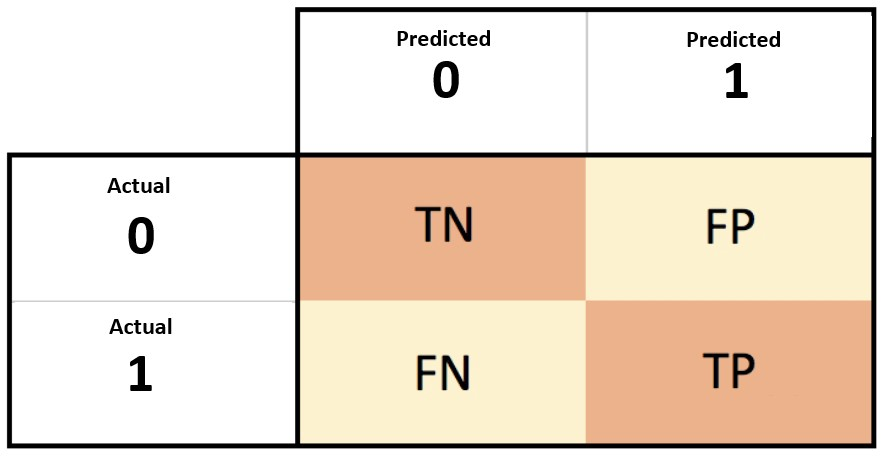

In [12]:
Image('/Users/AnaPSilva/Documents/Ana/Ironhack/Bootcamp/Week7/7.Day4/confusion_matrix.jpeg')

In [8]:
# Your code here
X = fraud.drop(['isFraud','nameOrig','nameDest'],axis=1)
y = fraud['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

LR = LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test, y_test) ##Accuracy
pred = LR.predict(X_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24964
           1       0.26      0.44      0.33        36

    accuracy                           1.00     25000
   macro avg       0.63      0.72      0.66     25000
weighted avg       1.00      1.00      1.00     25000



array([[24919,    45],
       [   20,    16]])

### Now pick a model of your choice and evaluate its accuracy.

In [16]:
# Your code here
sm = SMOTE(random_state=1, sampling_strategy=0.05) ## sampling strategy mean I end up with a ratio of 1 between minority class/majority class


X_train_smote, y_train_smote = sm.fit_resample(X_train,y_train)

LR= LogisticRegression(max_iter=1000)
LR.fit(X_train_smote,y_train_smote)

pred = LR.predict(X_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)
## The recall of 0.95 is a better score as in this case I'm now 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24964
           1       0.08      0.78      0.14        36

    accuracy                           0.99     25000
   macro avg       0.54      0.88      0.57     25000
weighted avg       1.00      0.99      0.99     25000



array([[24635,   329],
       [    8,    28]])

### Which model worked better and how do you know?

In [10]:
# Your response here
## SMOTE model is better as it balances the data in a way that favors the recall.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.